In [1]:
import pandas as pd
import numpy as np
import json
from BCBio import GFF
import pprint
import subprocess
from phytreeviz import TreeViz
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Patch
from matplotlib.patches import Rectangle
from sklearn.metrics import adjusted_rand_score

m = ["roary","panacota","peppan","pirate","panaroo","panta","panX","panXX"]
c = list(plt.get_cmap("Set2").colors[:8])
c2 = list(plt.get_cmap("Pastel2").colors[:8])
colors=dict(zip(m,c))
colors2=dict(zip(m,c2))

In [2]:
dataset="400_4"
organism="Ecoli"
n_genomes = 400
METHODS = ["roary","panacota","panaroo","panta","peppan","panX","panXX"]

In [3]:
def get_hash(locus_list):
    locus_list.sort()
    return hash(frozenset(locus_list))

def get_idx(locus_list):
    if any("PEPPAN" in l for l in locus_list):
        return True
    else:
        return False

In [7]:
df = pd.DataFrame(columns=["methods","count","locus","hash","agreement"])
all_labels = pd.DataFrame(columns=["method","geneId","locus"])

loci = {}
for method in METHODS:
    loci[method] = [x for x in set(pd.read_json(f"bench-{organism}/{dataset}-{method}.json")["locus"].explode("locus")) if x==x]

common_loci = set()
all_loci = set()
for m,l in loci.items():
    if len(common_loci)>0:
        common_loci &= set(l)
    else:
        common_loci = set(l)
    all_loci = all_loci.union(set(l))
print(f"Found {len(all_loci)} loci")
print(f"Found {len(common_loci)} common loci")

Found 1966195 loci
Found 1811140 common loci


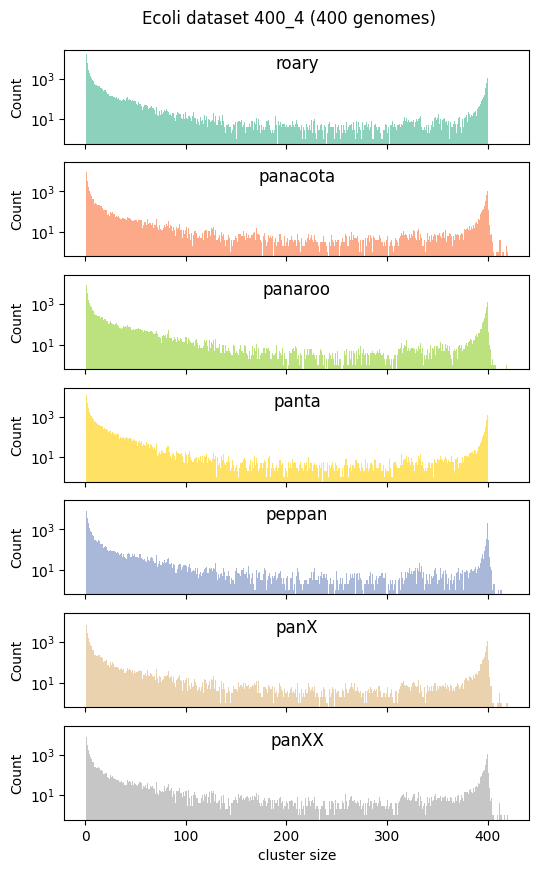

In [10]:
#------------------------------------------#
#        plot count distribution 
#------------------------------------------#
fig,axes = plt.subplots(ncols=1,nrows=len(METHODS),sharex=True,sharey=True,figsize=(6,10))

MAX=420

for i in range(len(METHODS)):
    method=METHODS[i]
    counts = pd.read_json(f"bench-{organism}/{dataset}-{method}.json")["count"]
    #ignore clusters above n_genomes + 5
    c = counts[(counts>0)&(counts<=MAX)]
    ax = axes[i]
    sns.histplot(data=c,color=colors[method],edgecolor=None,ax=ax,discrete=True)
    ax.set_title(method,y=1.0,pad=-14)
    ax.set_yscale("log")
    ax.set_xlabel("cluster size")

fig.suptitle(f"Ecoli dataset {dataset} (400 genomes)",y=0.92)

# fig.tight_layout()

plt.show()

In [ ]:
#------------------------------------------#
#          plot general numbers 
#------------------------------------------#

c = [colors[method] for method in METHODS]
data = pd.DataFrame()
dataset="400_1"

for method in METHODS:
    df = pd.read_json(f"bench-{organism}/{dataset}-{method}.json")
    sing = len(df[df["singleton"]=="yes"])
    sccg = len(df[df["sccg"]=="yes"])
    total = len(df)
    data[method] = [total,sccg,sing]

data = data.T.rename(columns={0:"total clusters",1:"sccg",2:"singleton"})

fig,axes = plt.subplots(ncols=3,nrows=1,sharex=True,sharey=False)

axes[0].bar(data.index,data["total clusters"],color=c)
axes[0].set_title("total clusters")
axes[0].tick_params(axis="x",labelrotation=90)

axes[1].bar(data.index,data["sccg"],color=c)
axes[1].set_title("sccg")
axes[1].tick_params(axis="x",labelrotation=90)

axes[2].bar(data.index,data["singleton"],color=c)
axes[2].set_title("singleton")
axes[2].tick_params(axis="x",labelrotation=90)

fig.suptitle(f"Ecoli {dataset} dataset",size=20)

fig.tight_layout()
plt.show()

In [4]:
DATASETS = [100,200,300,400,500]
c = [colors[method] for method in METHODS]*len(DATASETS)
data = pd.DataFrame(columns=["method","type","count","dataset"])

for method in METHODS:
    for dataset in DATASETS:
        for i in range(1,6):
            try:
                df = pd.read_json(f"bench-{organism}/{dataset}_{i}-{method}.json")
            except:
                continue
            data.loc[len(data)] = [method,"total",len(df[df["singleton"]=="yes"]),dataset]
            data.loc[len(data)] = [method,"sccg",len(df[df["sccg"]=="yes"]),dataset]
            data.loc[len(data)] = [method,"singleton",len(df),dataset]

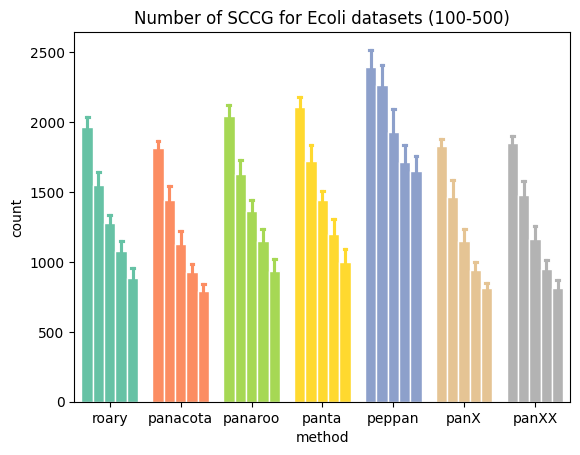

In [84]:
fig,ax = plt.subplots(ncols=1,nrows=1)
capsize=.2
bars = sns.barplot(data=data[data["type"]=="sccg"],x="method",y="count",hue="dataset",width=0.8,ax=ax,capsize=capsize)

for i,b in enumerate(filter(lambda x: isinstance(x, Rectangle), bars.get_children())):
    h = b.get_height()
    if h not in (0,1):
        b.set_color(c[i])
        b.set_edgecolor("w")

patches = ax.patches
for i, line in enumerate(ax.get_lines()):
    newcolor = patches[i].get_facecolor()
    line.set_color(newcolor)


ax.legend().remove()
ax.set_title("Number of SCCG for Ecoli datasets (100-500)")
plt.show()

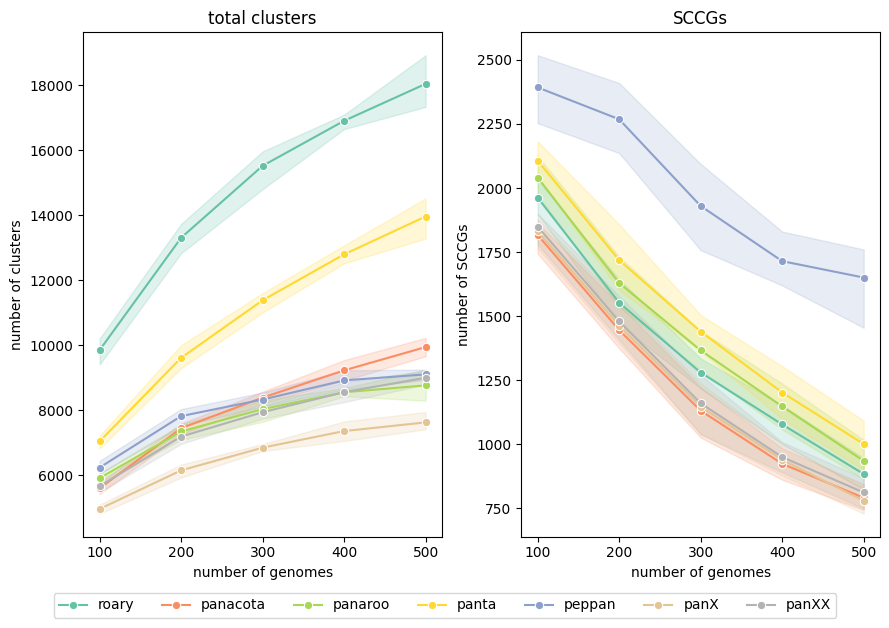

In [27]:
fig,(ax1,ax2) = plt.subplots(nrows=1,ncols=2,sharex=True,figsize=(9,6))

sns.lineplot(data=data[data["type"]=="total"],x="dataset",y="count",hue="method",ax=ax1,palette=colors,marker="o")
sns.lineplot(data=data[data["type"]=="sccg"],x="dataset",y="count",hue="method",ax=ax2, palette=colors, marker="o")

ax1.set_title("total clusters")
ax2.set_title("SCCGs")

ax1.set_xlabel("number of genomes")
ax1.set_ylabel("number of clusters")

ax2.set_xlabel("number of genomes")
ax2.set_ylabel("number of SCCGs")

handles, labels = ax1.get_legend_handles_labels()
ax1.get_legend().remove()
ax2.get_legend().remove()

fig.legend(handles,labels,ncols=7,loc="outside lower center",bbox_to_anchor=(0,-0.05,1,1.05))
fig.tight_layout()

fig.savefig("ecoli-total-cluster-sccg.png",dpi=300)
plt.show()


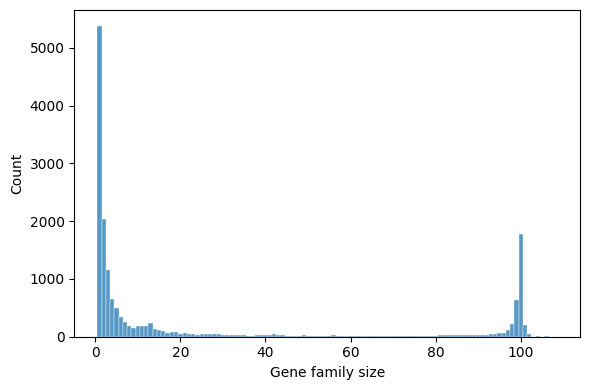

In [26]:
#------------------------------------------#
#        plot count distribution 
#------------------------------------------#
fig,ax = plt.subplots(ncols=1,nrows=1,figsize=(6,4))

MAX=110
dataset="100_1"
method="panXX"
counts = pd.read_json(f"bench-{organism}/{dataset}-{method}.json")["count"]
c = counts[(counts>0)&(counts<=MAX)]
h = sns.histplot(data=c,edgecolor="w",ax=ax,discrete=True)
ax.set_xlabel("Gene family size")

fig.tight_layout()
fig.savefig("pan-genome-distribution.png",dpi=300)

plt.show()

In [ ]:
METHODS = ["roary","panacota","peppan","panaroo","panta","panX","panXX"]
organism="Ecoli"
DATASETS = ['100_1', '100_2', '100_3', '100_4', '100_5']
n_genomes=100

In [ ]:
#-------------------------------------------#
#        collect data ARI heatmap                
#-------------------------------------------#

out_df = pd.DataFrame(columns=["dataset","reference","method","ARI"])

for dataset in DATASETS:
    print(f"Working on dataset: {dataset}")
    for ref_method in METHODS:
        print(f"reference: {ref_method}")
        ref_labels = pd.read_json(f"bench-{organism}/{dataset}-{ref_method}.json")[["geneId","locus"]].explode("locus",ignore_index=True).sort_values("locus").reset_index(drop="index")

        for method in METHODS:
            if ref_method!=method:
                method_labels = pd.read_json(f"bench-{organism}/{dataset}-{method}.json")[["geneId","locus"]].explode("locus",ignore_index=True)

                df = pd.merge(left=ref_labels,right=method_labels,how="inner",on="locus",suffixes=["_r","_m"])

                ARI=adjusted_rand_score(df["geneId_r"],df["geneId_m"])
                out_df.loc[len(out_df)]=[dataset.split("_")[0],ref_method,method,ARI]
            else:
                out_df.loc[len(out_df)]=[dataset.split("_")[0],ref_method,method,0]
    print("Done!")

In [ ]:
#-------------------------------------------#
#             plot ARI heatmap
#-------------------------------------------#

# out_df.to_csv("ARI-100.csv")
out_df = pd.read_csv("ARI-100.csv")
grouped = out_df.groupby(by=["reference","method"])[["ARI"]].mean().reset_index()

ari=grouped.ARI.to_numpy().reshape(7,7)
METHODS.sort()
fig, ax = plt.subplots()
sns.heatmap(ari, xticklabels=METHODS,yticklabels=METHODS,vmin=0.92,cbar=False,cmap="viridis",ax=ax)

# Loop over data dimensions and create text annotations.
for i in range(7):
    for j in range(7):
        if i!=j:
            ax.text(j+0.5, i+0.5, "%0.2f" % (ari[i, j]),horizontalalignment="center",verticalalignment="center",color="w")

plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

ax.set_aspect(1)
fig.tight_layout()

fig.savefig("ARI-100.png")
plt.show()